# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 26

**Author 1 (sciper):** Andrea Oliveri (283506)  
**Author 2 (sciper):** Charles Berger (272018)   
**Author 3 (sciper):** Chun Hei Michael Chan (311722)  

**Release date:** 26.03.2021  
**Due date:** 23.04.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## 0. Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
data_part1 = os.path.join(data_base_path, data_folder, 'part1')
data_part2 = os.path.join(data_base_path, data_folder, 'part2')

tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try:
1. Fourier Descriptors (15pts). 
    1. Implementation (10 pts).
    2. Showing invariance to rotation, translation and scaling (5 pts).
2. Additional method of your choice (5 pts)


**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point. Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

### 1.1 Data visualization

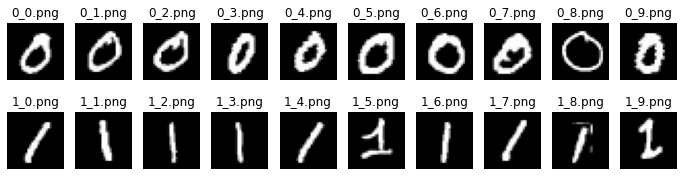

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

def load(path, digit='0'):
    digit_path = os.path.join(path, digit)
    digit_names = [nm for nm in os.listdir(digit_path) if '.png' in nm]  # make sure to only load .png
    digit_names.sort()  # sort file names
    ic = skimage.io.imread_collection([os.path.join(digit_path, nm) for nm in digit_names])
    digit_im = skimage.io.concatenate_images(ic)
    return digit_im, digit_names
                        
#  Load zeros and ones
zeros_im, zeros_names = load(data_part1, digit='0')
ones_im, ones_names = load(data_part1, digit='1')


# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors (15 pts)

In [3]:
import cv2 as cv
import numpy as np

def get_fourier_descriptor(image, n_coefficients_to_keep = 2):
    """
    Function returning a Fourier descriptor of image made by keeping the first n_coefficients_to_keep coefficients
    (not including the bias coefficient).
    
    Args:
        image::[np.array]
            Image we want to compute the Fourier descriptor of.
        n_coefficients_to_keep::[int]
            Number of coefficients (not including the bias coefficient) to keep to make up the Fourier descriptor.
    Returns:
        fourier_descriptor::[np.array]
            Array of size (n_coefficients_to_keep, ) where each element is one Fourier descriptor coefficient.
    """
    # Compute outer contours of image.
    _, contours, _ = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    
    # Isolating longest contour from the rest
    len_contours = [len(contour) for contour in contours]
    idx_longest_contour = np.argmax(len_contours)
    contour = contours[idx_longest_contour].squeeze()    
    
    # Make complex signal from contour array.
    complex_contour_signal = contour[:, 0] + 1j * contour[:, 1]
    
    # Compute fourier coefficients.
    fourier_coefficients = np.fft.fft(complex_contour_signal)
    
    # To make fourier coefficient resistant to scaling, ratio between coefficients is used instead of actual magnitude.
    fourier_coefficients = fourier_coefficients / fourier_coefficients[0]  
    
    # To make fourier coefficient resistant to translation, first coefficient discarded.
    fourier_coefficients = fourier_coefficients[1:]
    
    # To make fourier coefficient resistant to rotation, phase is discarded.
    fourier_coefficients = np.abs(fourier_coefficients)  
    
    return fourier_coefficients[:n_coefficients_to_keep]


def pretreat_image(image):
    """
    Function performing a basic pretreatement of the image to remove high-frequency noise and binarize it.
    
    Args:
        image::[np.array]
            Image we want to remove noise from and binarize. 
    Returns:
        image_binary::[np.array]
            Binary image of same size as image parameter obtained after median filtering and binary thresholding.
    """
    image_uniform_background = np.where(image > 50, image, 0)
    image_denoised = cv.medianBlur(image_uniform_background, 3)
    image_binary = (image_denoised > 20).astype(np.uint8)
    
    return image_binary


def plot_descriptors(coefficients_digits_list, marker_digits_list, label_digits_list, xlabel, ylabel):
    """
    Function making a scatter plot of the first two elements of each descriptor in coefficients_digits_list 
    using the corresponding marker in marker_digits_list and legend label in label_digits_list.
    
    Args:
        coefficients_digits_list::[np.array]
            Array of shape (n_digits, n_images_per_digit, >=2) containing for each digit type and each image
            per digit type an image descriptor of size larger or equal to 2.
        marker_digits_list::[list]
            List of size (n_digits, ) containing the marker to use in the scatter plot for each different digit.
        label_digits_list::[list]
            List of size (n_digits, ) containing the label to use in the legend for each different digit.
        xlabel::[string]
            Label to use on the horizontal axis.
        ylabel::[string]
            Label to use on the vertical axis.
    Returns:
        None
    """    
    assert(len(coefficients_digits_list) == len(marker_digits_list) == len(label_digits_list))
    
    for coefficients_digit, marker, label in zip(coefficients_digits_list, marker_digits_list, label_digits_list):
        plt.scatter(coefficients_digit[:, 0], coefficients_digit[:, 1], marker = marker, label = label)
        
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

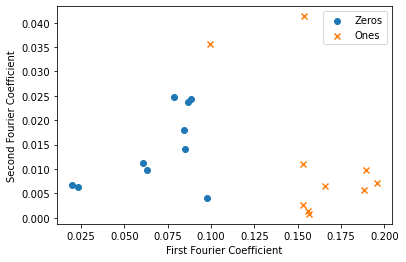

In [4]:
coefficients_zeros = np.asarray([get_fourier_descriptor(pretreat_image(img)) for img in zeros_im])
coefficients_ones  = np.asarray([get_fourier_descriptor(pretreat_image(img)) for img in ones_im])

plot_descriptors([coefficients_zeros, coefficients_ones], ['o', 'x'], ["Zeros", "Ones"],
                 "First Fourier Coefficient", "Second Fourier Coefficient")

<b>Invariance to rotation, translation and scaling</b>

In [5]:
def rotate(image, deg):
    """
    Function returning image rotated by deg degrees counter-clockwise around its center.
    
    Args:
        image::[np.array]
            Image we wish to rotate.
        deg::[float]
            Rotation angle in degrees. Positive values mean counter-clockwise rotation.
    Returns:
        result::[np.array]
            Image rotated by deg degrees counter-clockwise around its center.
    """
    rows, cols = image.shape
    matrix = cv.getRotationMatrix2D((cols/2, rows/2), deg, 1)
    result = cv.warpAffine(image, matrix, (cols, rows), flags = cv.INTER_CUBIC)

    return result
    
def translate(image, dx, dy):
    """
    Function returning image translated by dx pixels horizontally and dy pixels vertically.
    
    Args:
        image::[np.array]
            Image we wish to translate.
        dx::[int]
            Number of pixels we want to translate image horizontally. Positive values mean translation to the right.
        dy::[int]
            Number of pixels we want to translate image vertically. Positive values mean translation downwards.
    Returns:
        result::[np.array]
            Image translated by dx pixels horizontally and dy pixels vertically.
    """
    rows, cols = image.shape
    matrix = np.float32([[1, 0, dx], [0, 1, dy]])
    result = cv.warpAffine(image, matrix, (cols, rows))
    
    return result 

def scale(image, factor):
    """
    Function returning image zoomed in/out by factor.
    
    Args:
        image::[np.array]
            Image we wish to zoom in/out.
        factor::[float]
            Zooming factor. Values > 1 mean zoom-in. Values < 1 mean zoom-out.
    Returns:
        cropped::[np.array]
            Image of same shape as input image containing the central section of the zoomed-in image 
            (cropped to have same shape as input image) if factor > 1 and the zoomed-out image (padded
            to have same shape as input image) if factor < 1.
    """
    rows, cols = image.shape
    
    if factor == 1.:
        return image
    
    elif factor < 1.:
        scaled = cv.resize(image, None, fy = factor, fx = factor, interpolation = cv.INTER_AREA)
        new_rows, new_cols = scaled.shape
        
        delta_rows = rows - new_rows
        delta_cols = cols - new_cols

        top    = delta_rows // 2
        bottom = delta_rows - top
        left   = delta_cols // 2
        right  = delta_cols - left
        
        padded = np.pad(scaled, ((top, bottom), (left, right)), 'edge')
        
        return padded
        
        
    scaled = cv.resize(image, None, fy = factor, fx = factor, interpolation = cv.INTER_CUBIC)
    new_rows, new_cols = scaled.shape

    delta_rows = new_rows - rows
    delta_cols = new_cols - cols

    top    = delta_rows // 2
    bottom = delta_rows - top
    left   = delta_cols // 2
    right  = delta_cols - left   
 
    cropped = scaled[top:-bottom, left:-right]
    
    return cropped

In [6]:
def compute_coefficient_of_variation_after_transformation(transformation, get_descriptor_func, all_digits_images, list_params_to_transform):
    """
    Function estimating the coefficient of variation by performing different degrees of transformation 
    (rotation, translation, scaling) of each image in all_digits_images, computing the image descriptor for each
    transformed image, computing the coefficient of variation across all transformations for each image, and averaging
    the obtained coefficients of variance across all images to obtain a metric of invariance of descriptor to the
    transformation.
    
    Args:
        transformation::[function]
            Function to call with parameters in list_params_to_transform to perform a deformation of an input image.
        get_descriptor_func::[func]
            Function to call to obtain an image descriptor from any given image.
        all_digits_images::[list]
            List of np.array where each element is an image we want to perform several deformations on and then
            compare the coefficient of variation on for each coefficient of the descriptor generated from each
            deformed image.
        list_params_to_transform::[list]
            List of parameters to pass to transformation function. Each line must contain all parameters that said
            function requires in one call. 
    Returns:
        average_across_digits_coefficients_of_variation::[np.array]
            Metric of invariance of descriptor to the transformation obtained by performing different degrees
            of transformation of each image in all_digits_images, computing the image descriptor for each
            transformed image, computing the coefficient of variation across all transformations for each image 
            and averaging the obtained coefficients of variance. Each element is a metric of invariance for 
            the corresponding coefficient from the descriptor.
    """    
    all_images = [[transformation(img, *params) for img in all_digits_images] for params in list_params_to_transform]
    
    all_coefficients = np.asarray([[get_descriptor_func(pretreat_image(img)) for img in all_images_line] for all_images_line in all_images])
    
    coefficients_of_variation = all_coefficients.var(axis = 0) / all_coefficients.mean(axis = 0)
        
    average_across_digits_coefficients_of_variation = coefficients_of_variation.mean(axis = 0)

    return average_across_digits_coefficients_of_variation

In [7]:
var_coefs = compute_coefficient_of_variation_after_transformation(rotate, get_fourier_descriptor, 
                                                                  [*zeros_im, *ones_im], 
                                                                  np.linspace(0, 360, 18, endpoint=False).reshape((-1, 1)))

print("Average over all images of variance across all rotations:")
print("    First Coef : {:.2g}\n    Second Coef: {:.2g}\n".format(*var_coefs))


var_coefs = compute_coefficient_of_variation_after_transformation(translate, get_fourier_descriptor, 
                                                                  [*zeros_im, *ones_im], 
                                                                  [[dx, dy] for dx in range(-2, 3) for dy in range(-2, 3)])

print("Average over all images of variance across all translations:")
print("    First Coef : {:.2g}\n    Second Coef: {:.2g}\n".format(*var_coefs))


var_coefs = compute_coefficient_of_variation_after_transformation(scale, get_fourier_descriptor, 
                                                                  [*zeros_im, *ones_im], 
                                                                  np.linspace(0.6, 1.2, 13).reshape((-1, 1)))

print("Average over all images of variance across all scalings:")
print("    First Coef : {:.2g}\n    Second Coef: {:.2g}\n".format(*var_coefs))

Average over all images of variance across all rotations:
    First Coef : 0.00027
    Second Coef: 0.0007

Average over all images of variance across all translations:
    First Coef : 0.00059
    Second Coef: 6.8e-05

Average over all images of variance across all scalings:
    First Coef : 0.0057
    Second Coef: 0.0015



#### Discussion
##### Description of the processing  to compute the Fourier Descriptor: 

- Pre-processing:
    <br>
   
    - For every pixel in the image with an intensity value below 50, we substitute its intensity with zero in order to uniform the background.
    <br>
    
    - We apply a median filter of size 3 to remove high-frequency noise (in the form of white pixel not belonging to the object) while preserving the edge.
    <br>


- Processing:
    
     1. We extract the outer contour of the object and store in an array of size (n_pixels_contour, 2) where the first column represents the x coordinate of the pixel and the second column the y coordinate. 
    <br>
    
     2. We transform this array into a complex signal by computing, for every contour pixel (every row in our array): $x + jy$
    <br>
    
     3. We apply the Fast Fourier Transform (FFT) to get the Fourier Descriptors' coefficients.
    <br>
    
     4. We make a set of transformation on the fourier coefficients in order to make the final descriptor invariant to translation, rotation and scaling. To do so, we divide all coefficients by the first one (this allows invariance to scaling), we ignore their phase (hence we only keep their magnitude to make them invariant to rotation) and we discard the first coefficient (to make the final descriptor invariant to translation).
    <br>
    
     5. To make our Fourier Descriptor, as we only wish to use two features, we remove all coefficients but the first 2 (after discarding the bias coefficient), as low-frequencies are more important at describing general shapes than high frequencies.
    <br>
    
     7. To visualize the results, we plot the obtained Fourier Descriptors for each label on a 2D plane.
    <br>    


##### Description of the processing  to test invariance to scaling, rotation and translation of the Fourier Descriptor: 

- Pre-processing:
    <br>
   
    - Each image in the dataset (for all digits) is rotated, scaled or translated by different amounts equally spaced in a range chosen such that no parts of the object in the image end up ouside of the new image. All the resulting images are stored.
    <br>


- Processing:
    
     1. The Fourier descriptor is computed for each of the transformed images, using the pre-processing and processing described in the previous section. 
     <br>
    
     2. The coefficient of variation, obtained by $cv = \frac{variance}{mean}$ is computed across the Fourier descriptors computed from all transformation of the same original image.
    <br>
    
     3. The average of the coefficients of variation across all images is taken as a metric to determine invariance to the transformation. 
     <br>    


##### General comment on method

- Fourier Descriptor method is a fast and efficient way to describe an object based on its contour. Often only a small number of coefficients must be kept to obtain good classification results, which is good as it reduces the impact of the Curse of Dimentionality during training of a classifier, which therefore needs less training samples and can generalize better. Moreover, they can easily be made invariant to rotation, translation and scaling of the object in the image.
    <br/>

- The main drawback of the Fourier descriptor methods is that the number of Fourier coefficients to keep in our Fourier descriptor in order to obtain good classification results is not always easy to determine. For exemple, in the above case we see that only 2 Fourier coefficients are enough to get good classification results (in classifying 0 vs 1), but in the second part of the lab (where we have to classify images of 0, 1, 2 and 3), we see that only two coefficients are not sufficient.
    <br/>

- Using the coefficient of variation (index of dispersion) as a metric to determine the invariance of features to a transformation is an easy and efficient technique to measure the variance of the descriptor across transformation without being impacted by the numerical size of the feature (features with a small scale may appear to have a small variance compared to features with a large scale, even though their coefficient of variation, which is irrispective of scale, is the same). This metric may not be ideal, and involves empirically calculating several transformations and descriptors for a lot of images, but works well enough to prove invariance of our Fourier descriptor to scaling, rotation and translation. As the definition of the metric indicates, we can then compare the quality of invariance across shapes (either 0 or 1) or across transformations (scaling, translation, rotation)


##### Comment on results

- The inter class variance of the Fourier Descriptor across different classes is large enough that the two classes can easily be distinguised.
  <br/>

- The intra class variance is small enough, compared to the inter class variance, for the two classes to be well separable.
  <br/>
  
- Only 2 coefficients (hence 2 features) are needed to perform classification with unitary train accuracy.
  <br/>

- The coefficient of variation of the Fourier descriptor across different degrees of scaling, rotation and transformation are very small (always less than 1%, and often much smaller). It is not plain zero as the transformations inevitably introduce slight distortions in the image which can cause the descriptor to be slightly different. Nevertheless, the very small values measured for the coefficients of variation measured by our tests prove that the resulting Fourier descriptor is invariant to scaling, rotation and translation of the object in the image (provided the entirety of the object is visible in the image, i.e. no parts of the object leave the image as a result of the transformation).
  <br/>
  
- `Conclusion`: The Fourier Descriptor method keeping only 2 coefficients is very effective at classifying our dataset.


##### Comparison to other methods

- Comparison to Hu Moments:
    <br/>
      
    - For the zero images: The Hu moments give a smaller intra class variance than the Fourier Descriptors. 
    <br/>
    
    - For the one images: The Hu moments give a larger intra class variance than the Fourier Descriptors.
    <br/>
    
    - The inter class variance appears larger in the Hu Moments than in the Fourier descriptor. 
    <br/>
    
    - In both cases, it is sufficiently large compared to the intra class variances that both methods have succeded in classifying correctly the dataset.

### 1.3 Additional method (5 pts)

In [8]:
def get_hu_moments_descriptor(image, moments_to_keep = (1, 2)):
    """
    Function returning the Hu Moments at positions moments_to_keep computed from image.
    
    Args:
        image::[np.array]
            Image we want to compute the Hu Moments descriptor of.
        moments_to_keep::[tuple]
            Which of the computed Hu Moments we want to use to make up the image descriptor.
    Returns:
        hu_moments_descriptor::[np.array]
            Array of size (len(moments_to_keep), ) where each element is one Hu Moments descriptor coefficient.
    """
    moments    = cv.moments(image)
    hu_moments = cv.HuMoments(moments).flatten()
    
    return hu_moments[np.array(moments_to_keep)]

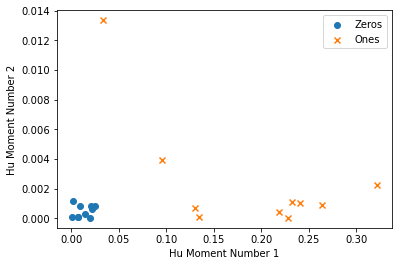

In [9]:
hu_moments_zeros = np.asarray([get_hu_moments_descriptor(pretreat_image(img)) for img in zeros_im])
hu_moments_ones  = np.asarray([get_hu_moments_descriptor(pretreat_image(img)) for img in ones_im])

plot_descriptors([hu_moments_zeros, hu_moments_ones], ['o', 'x'], ["Zeros", "Ones"],
                 "Hu Moment Number 1", "Hu Moment Number 2")

<b>Invariance to rotation, translation and scaling</b>

In [10]:
var_coefs = compute_coefficient_of_variation_after_transformation(rotate, get_hu_moments_descriptor, 
                                                                  [*zeros_im, *ones_im], 
                                                                  np.linspace(0, 360, 18, endpoint=False).reshape((-1, 1)))

print("Average over all images of variance across all rotations:")
print("    First Coef : {:.2g}\n    Second Coef: {:.2g}\n".format(*var_coefs))


var_coefs = compute_coefficient_of_variation_after_transformation(translate, get_hu_moments_descriptor, 
                                                                  [*zeros_im, *ones_im], 
                                                                  [[dx, dy] for dx in range(-2, 3) for dy in range(-2, 3)])

print("Average over all images of variance across all translations:")
print("    First Coef : {:.2g}\n    Second Coef: {:.2g}\n".format(*var_coefs))


var_coefs = compute_coefficient_of_variation_after_transformation(scale, get_hu_moments_descriptor, 
                                                                  [*zeros_im, *ones_im], 
                                                                  np.linspace(0.6, 1.2, 13).reshape((-1, 1)))

print("Average over all images of variance across all scalings:")
print("    First Coef : {:.2g}\n    Second Coef: {:.2g}\n".format(*var_coefs))

Average over all images of variance across all rotations:
    First Coef : 0.00064
    Second Coef: 0.00022

Average over all images of variance across all translations:
    First Coef : 1.3e-31
    Second Coef: 7.6e-30

Average over all images of variance across all scalings:
    First Coef : 0.0031
    Second Coef: 0.00049



#### Discussion
##### Description of the processing : 

- Pre-processing:
    <br>
   
    - The same pretreatement as for the Fourier descriptor is applied on the images. 
    <br>


- Processing:
    
     1. We compute the Hu moments from the obtained images using OpenCV's built-in function.
    <br>    


##### Description of the processing  to test invariance to scaling, rotation and translation of the Fourier Descriptor: 

- Pre-processing:
    <br>
   
    - Each image in the dataset (for all digits) is rotated, scaled or translated by different amounts equally spaced in a range chosen such that no parts of the object in the image end up ouside of the new image. All the resulting images are stored.
    <br>


- Processing:
    
     1. The Hu moments descriptor is computed for each of the transformed images, using the pre-processing and processing described in the previous section. 
     <br>
    
     2. The coefficient of variation, obtained by $cv = \frac{variance}{mean}$ is computed across the Fourier descriptors computed from all transformation of the same original image.
    <br>
    
     3. The average of the coefficients of variation across all images is taken as a metric to determine invariance to the transformation. 
     <br>  
     

##### General comment on method

- Image moments are computed from the pixels' repartition of an object in a image. More precisely, it's a weighted average of the intensities of pixels composing the object or a function of such intensities, which can be used to obtain informations about the area, the centroid and the orientation of the object. Hu moments can be computed from image moments and are invariant to translation, rotation and scaling of the object in the image. There are a total of 7 Hu moments, with the first 6 being reflection symmetric (i.e. they are invariant to mirroring of the object in the image) and the 7th one not. 
    <br/>
   
- As for the Fourier descriptor, only 2 moments (hence 2 features) are needed to perform classification with unitary train accuracy.
    <br/>

- The main disadvantages with Hu moments are that they are not independent, as some can be expressed as a combination of the others, and that it is not always easy to determine which subset of Hu moments should be used in order to get good classification results. 
    <br/>
    
- The same comment about the coefficient of variation as in the Fourier Descriptor section still applies.


##### Comment on results

- The inter class variance of the Fourier Descriptor across different classes is large enough that the two classes can easily be distinguised.
  <br/>

- The intra class variance is small enough, compared to the inter class variance, for the two classes to be well separable.
  <br/>
  
- Only 2 coefficients (hence 2 features) are needed to perform classification with unitary train accuracy.
  <br/>

- The coefficient of variation of the Fourier descriptor across different degrees of scaling, rotation and transformation are very small (always less than 1%, and often much smaller). It is not plain zero as the transformations inevitably introduce slight distortions in the image which can cause the descriptor to be slightly different. Nevertheless, the very small values measured for the coefficients of variation measured by our tests prove that the resulting He moments descriptor is invariant to scaling, rotation and translation of the object in the image (provided the entirety of the object is visible in the image, i.e. no parts of the object leave the image as a result of the transformation).
  <br/>
  
- `Conclusion`: The He Moments Descriptor method keeping only 2 He moment invariants is very effective at classifying our dataset.


##### Improvements and alternative approaches 

- Which He Moments to keep for our descriptor is an hyper-parameter which may be chosen automatically by cross-validation if we had chosen our classifier. 
  <br/>


##### Comparison to other methods

- Comparison to Fourier Descriptor:
    <br/>
      
    - For the zero images: The Hu moments give a smaller intra class variance than the Fourier Descriptors.
    <br/>
    
    - For the one images: The Hu moments give a larger intra class variance than the Fourier Descriptors.
    <br/>
    
    - The inter class variance appears larger in the Hu Moments than in the Fourier descriptor. 
    <br/>
    
    - In both cases, the inter class variance is sufficiently large compared to the intra class variances that both methods have succeded in classifying correctly the dataset.

---
## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

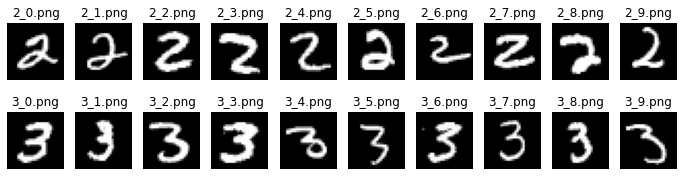

In [11]:
#  Load twos and threes
twos_im, twos_names = load(data_part2, digit='2')
threes_im, threes_names = load(data_part2, digit='3')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Fourier descriptors - 4 digits (10 pts)

In [12]:
coefficients_twos   = np.asarray([get_fourier_descriptor(pretreat_image(im)) for im in twos_im])
coefficients_threes = np.asarray([get_fourier_descriptor(pretreat_image(im)) for im in threes_im])

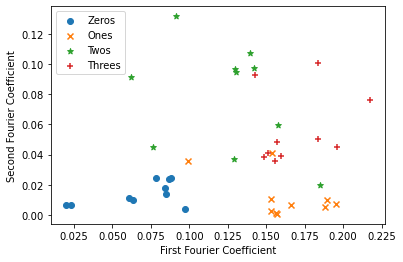

In [13]:
plot_descriptors([coefficients_zeros, coefficients_ones, coefficients_twos, coefficients_threes], 
                 ['o', 'x', '*', '+'], ["Zeros", "Ones", "Twos", "Threes"],
                 "First Fourier Coefficient", "Second Fourier Coefficient")

### Discussion : 

`The processing pipeline of the image, as well as the comments on the method made in the first Fourier Descriptors section are the same here.`

##### Comment on results

- The inter class variance of the Fourier Descriptor across different classes is too small compared to the intra class variance for the different classes to be easily separable from the others with good accuracy (with the exeption of 0, which could relatively easily be distinguished from the other classes). 
    <br/>

- `Conclusion`: 2 Fourier coefficients aren't sufficient to make a good enough feature for the images to be accuractely classified. More Fourier coefficients would need to be used to improve accuracy, but due to the curse of dimensionality in order to allow our model to still be able to generalize well, a larger training set would also be needed.